In [1]:
import numpy as np
import os
import re
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from tqdm import tqdm
tqdm.pandas()
import time
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
import gc
from glob import glob
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns

ERROR 1: PROJ: proj_create_from_database: Open of /project/cper_neon_aop/conda_envs/hls_nrt_env/share/proj failed


In [2]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/params')
from ltar_arch_params_smooth import *

In [11]:
from importlib import reload
import sys
reload(sys.modules["ltar_arch_params_smooth"])

<module 'ltar_reno_params_smooth' from '/project/cper_neon_aop/hls_nrt/params/ltar_reno_params_smooth.py'>

In [3]:
def adapt_smooth(ts, dates, despike=True, dat_thresh=None):
    ct_valid = sum(~np.isnan(ts))
    ct_total = len(ts)
    avg_gap = ct_total/ct_valid
    if ct_valid > 0:
        if avg_gap > 15:
            despike = False
        if despike:
            if dat_thresh is None:
                _dat_thresh = np.ptp(ts.values) * 0.10
            else:
                _dat_thresh = dat_thresh
            ts_ds = despike_ts(ts.values, dat_thresh=_dat_thresh, days_thresh=45)
        else:
            ts_ds = ts.values
        if avg_gap > 10:
            ts_smooth = double_savgol(ts_ds, double=True, window1_max=7, window2=31, limit=91)
        elif avg_gap > 7:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=41, limit=91)
        elif avg_gap > 5:
             ts_smooth = double_savgol(ts_ds, double=True, window1_max=5, window2=51, limit=91)
        else:
            ts_smooth = double_savgol(ts_ds, double=False, window2=51, limit=91)
    else:
        ts_smooth = ts
    return pd.Series(ts_smooth, ts.index.get_level_values(-1))

In [4]:
fLIST = glob(inPATH_wc)
df = pd.read_csv(inPATH_dat, parse_dates=[date_col])

In [5]:
if preprocess is not None:
    df = preprocess(df)

In [6]:
df.head(5)

,ID,Pasture,Treatment,Date,Date_mean,Year,Season,Low,High,Biomass_kg_ha,long,lat,PP_g,ID_yr
0,7,N,IMP,2020-12-09,2020-12-09,2020,12,19.0,23.33333333,692.0,-81.1804,27.1431,17.3,7_2020
1,7,N,IMP,2020-10-15,2020-10-15,2020,10,45.0,50.66666667,2808.0,-81.1804,27.1431,70.2,7_2020
2,7,N,IMP,2020-08-13,2020-08-13,2020,8,66.0,68.66666667,2372.0,-81.1804,27.1431,59.3,7_2020
3,7,N,IMP,2020-06-11,2020-06-11,2020,6,49.0,49.33333333,3288.0,-81.1804,27.1431,82.2,7_2020
4,7,N,IMP,2020-03-25,2020-03-25,2020,3,NaN,27,2060.0,-81.1804,27.1431,51.5,7_2020


In [35]:
yr = 2017

In [36]:
# get list of files that match year based on path
fLIST_yr = [x for x in fLIST if str(yr) in os.path.basename(x).split('_')]

# combine all individual tile files into one dataframe
df_yr = pd.concat([pd.read_csv(x, parse_dates=[1]) for x in fLIST_yr])

# rename columns to match ground data
df_yr = df_yr.rename(columns={'time': date_col,
                              'Plot': id_col})

# convert date to datetime
df_yr[date_col] = pd.to_datetime(df_yr[date_col])

# remove all non-plot data
#df_yr = df_yr[df_yr[id_col] != 'UNK']

# remove any dates where bands are negative
df_yr = df_yr[~((df_yr[band_list] < 0).any(axis=1))]

# drop any duplicates by taking mean for each plot and date (might exist e.g., from plot on edge of tile during extraction)
df_yr = df_yr.groupby([id_col, date_col]).mean().reset_index()

# get missing dates for gap-filling
dates_missing = [x for x in pd.date_range(df_yr[date_col].min(), df_yr[date_col].max()).date if x not in df_yr[date_col].dt.date.unique()]

# convert missing dates to a dataframe for combining with veg index data
df_missing = pd.DataFrame({
    id_col: list(chain.from_iterable([list(np.repeat(x, len(dates_missing))) for x in df_yr[id_col].unique()])),
    date_col: list(chain.from_iterable(dates_missing for x in df_yr[id_col].unique()))})

df_missing[date_col] = pd.to_datetime(df_missing[date_col])

# combine into one dataframe for gapfilling
df_yr_ts = pd.concat([df_yr, df_missing]).sort_values([id_col, date_col])

# apply Bolton mask to extracted values
if mask_bolton_by_id:
    ps_bolton = df_yr_ts.groupby(id_col).progress_apply(lambda x: bolton_mask_np(x['BLUE'], x['SWIR2']))
    df_yr_ts.loc[df_yr_ts[ps_bolton.droplevel(0) == 1.0].index, list(veg_dict.keys()) + band_list] = np.nan

# smooth all vegetation indices to gapfill
print('Smoothing vegetation indices')
for vegidx in tqdm(veg_list):
    #df_yr_ts[vegidx + '_smooth'] = df_yr_ts.groupby(id_col)[vegidx].transform(lambda x: double_savgol(x.values))
    vals_smooth_yr = df_yr_ts.groupby(id_col).apply(lambda x: adapt_smooth(x[vegidx], pd.to_datetime(x[date_col])))
    if vals_smooth_yr.index.nlevels > 1:
        df_yr_ts[vegidx + '_smooth'] = vals_smooth_yr.droplevel(list(np.arange(vals_smooth_yr.index.nlevels-1)))
    else:
        df_yr_ts[vegidx + '_smooth'] = vals_smooth_yr.values.squeeze()
print('Smoothing individual bands')
for band in tqdm(band_list):
    #df_yr_ts[band + '_smooth'] = df_yr_ts.groupby(id_col)[band].transform(lambda x: double_savgol(x.values))
    vals_smooth_yr = df_yr_ts.groupby(id_col).apply(lambda x: adapt_smooth(x[band], pd.to_datetime(x[date_col])))
    if vals_smooth_yr.index.nlevels > 1:
        df_yr_ts[band + '_smooth'] = vals_smooth_yr.droplevel(list(np.arange(vals_smooth_yr.index.nlevels-1)))
    else:
        df_yr_ts[band + '_smooth'] = vals_smooth_yr.values.squeeze()

Smoothing vegetation indices


100%|██████████| 22/22 [00:05<00:00,  3.68it/s]


Smoothing individual bands


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


In [47]:
# look for any missing data
df_yr_ts[df_yr_ts['NDVI_smooth'].isnull()].sort_values(id_col)

,index,ID_yr,Date_mean,NDVI,DFI,NDTI,SATVI,NDII7,SAVI,RDVI,...,BAI_146_smooth,BAI_236_smooth,BAI_246_smooth,BAI_346_smooth,BLUE_smooth,GREEN_smooth,RED_smooth,NIR1_smooth,SWIR1_smooth,SWIR2_smooth
173,156,113_2017,2017-07-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
192,19,113_2017,2017-08-13,0.870329,4.36043,0.458719,0.279776,0.746511,0.649533,61.239274,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,173,113_2017,2017-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
194,174,113_2017,2017-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
195,175,113_2017,2017-08-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24366,21228,86_2017,2017-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24367,21229,86_2017,2017-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24368,21230,86_2017,2017-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24360,21222,86_2017,2017-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
df_yr_ts[df_yr_ts.duplicated(subset=[id_col, date_col], keep=False)].sort_values(id_col)

,ID_yr,Date_mean,NDVI,DFI,NDTI,SATVI,NDII7,SAVI,RDVI,MTVI1,...,BAI_146_smooth,BAI_236_smooth,BAI_246_smooth,BAI_346_smooth,BLUE_smooth,GREEN_smooth,RED_smooth,NIR1_smooth,SWIR1_smooth,SWIR2_smooth


In [43]:
df_yr_ts = df_yr_ts.reset_index()

<AxesSubplot:xlabel='Date_mean', ylabel='SWIR1_smooth'>

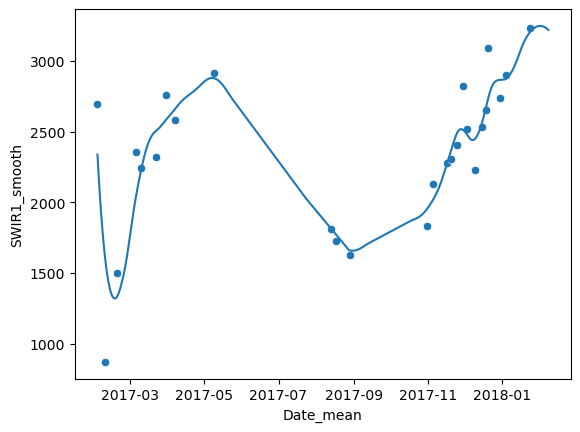

In [44]:
plot = df_yr_ts[id_col].unique()[10]
plot = '113_2017'
x_col = 'SWIR1'
p = sns.lineplot(x=date_col, y=x_col + '_smooth', data=df_yr_ts[df_yr_ts[id_col] == plot])
sns.scatterplot(x=date_col, y=x_col, data=df_yr[df_yr[id_col] == plot], ax=p)

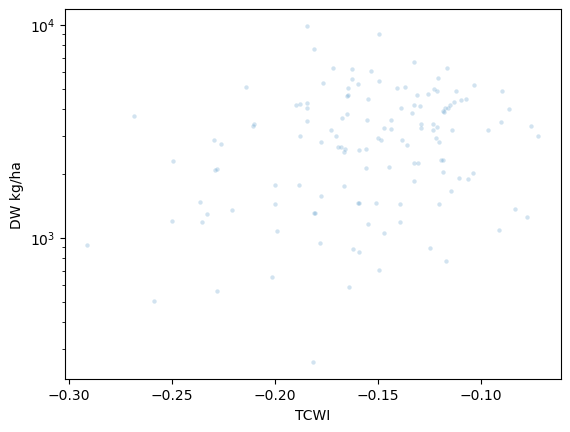

In [48]:
x_col = 'TCWI'
sns.scatterplot(x=x_col, y=y_col, data=df_out, alpha=0.2, linewidth=0, s=10)
plt.yscale('log')

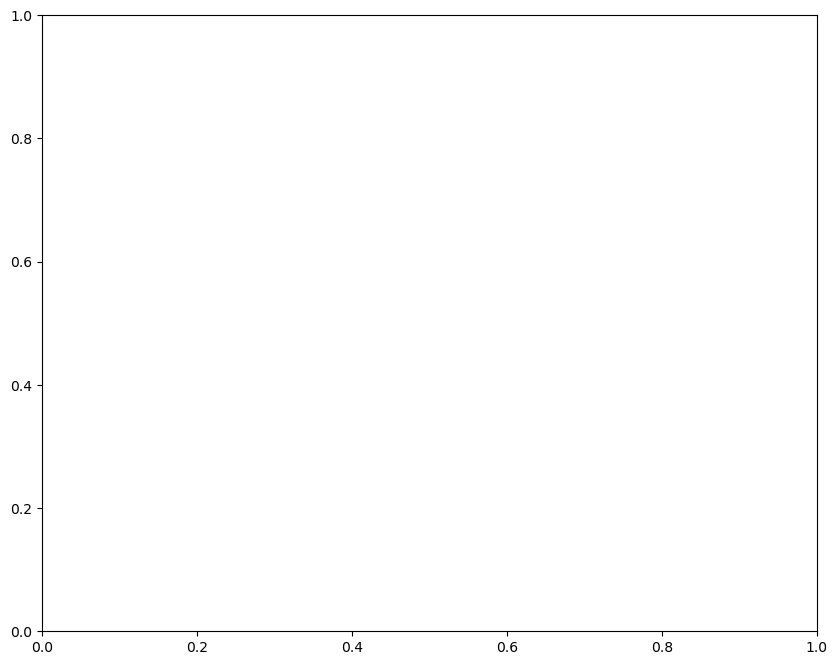

In [50]:
fig, ax = plt.subplots(figsize=(10, 8))
#sns.scatterplot(x=x_col, y=y_col, data=df_out, hue='Year', ax=ax)
#df_out.apply(lambda x: ax.text(x[x_col],  x[y_col], x[id_col]), axis=1)
#plt.yscale('log')